This notebooks want to explore [pymatch](https://github.com/benmiroglio/pymatch) package, to undesrtand how to identify if two partitions of the same dataset are similar or not.
This apply a lot to A/B tests where we have two populations and we want to make sure that the two polulations have the same carachteristics (distribution etc). If the two population are not similar we can also use pymatch to adjust for the error, by sampling similar data points.

In [1]:
from sklearn.datasets.samples_generator import make_blobs, make_moons, make_circles
from matplotlib import pyplot
from pandas import DataFrame
from pymatch.Matcher import Matcher

import numpy as np
import pandas as pd

In [2]:
pyplot.rcParams['figure.figsize'] = [20, 10]
pyplot.rcParams["font.size"] = 18

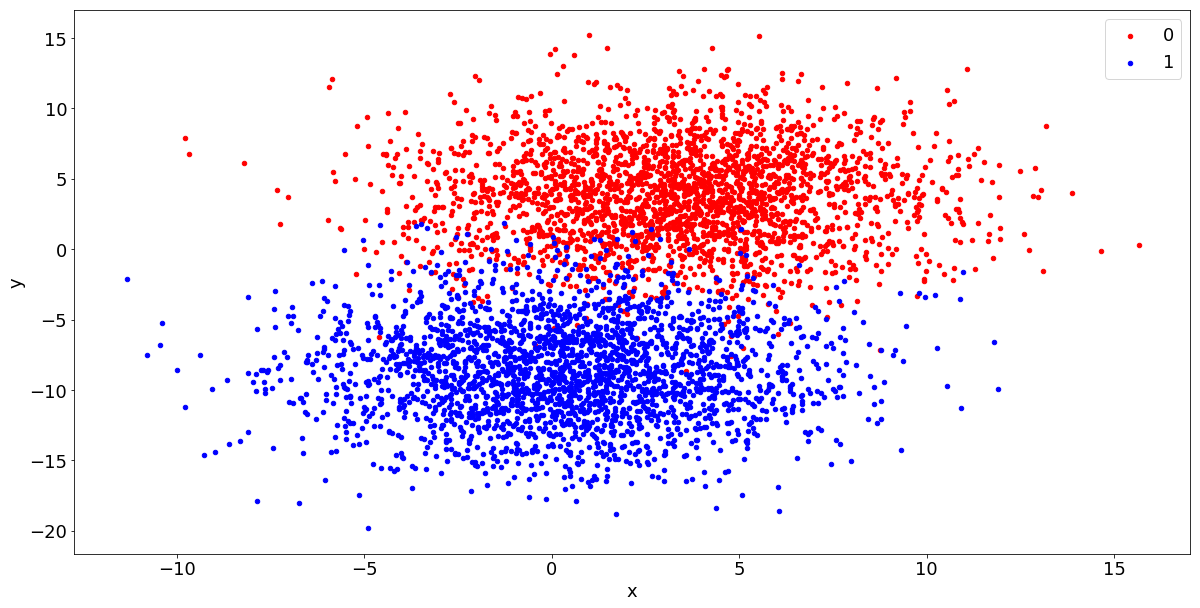

In [3]:
# generate 2d classification dataset
X, y = make_blobs(n_samples=5000, centers=2, n_features=2, cluster_std=3.5)
# X, y = make_moons(n_samples=100, noise=0.1)
# X, y = make_circles(n_samples=100, noise=0.05)

# scatter plot, dots colored by class value
df = DataFrame(dict(x=X[:,0], y=X[:,1], label=y))
colors = {0:'red', 1:'blue', 2:'green'}
fig, ax = pyplot.subplots()
grouped = df.groupby('label')
for key, group in grouped:
    group.plot(ax=ax, kind='scatter', x='x', y='y', label=key, color=colors[key])
pyplot.show()

In [4]:
df.groupby('label').size()

label
0    2500
1    2500
dtype: int64

## Let's compare two subsets of data that are randomly selected, and see what pymatch tell us

In this case we assign to one population group or the other randomly. Therefore the hypotesis is that the two groups should be completely overlapping, and pymatch will tell us that the two groups have similar propensity scores

In [5]:
df['population'] = np.random.choice([1, 0], size=len(df), p=[0.8, 0.2])

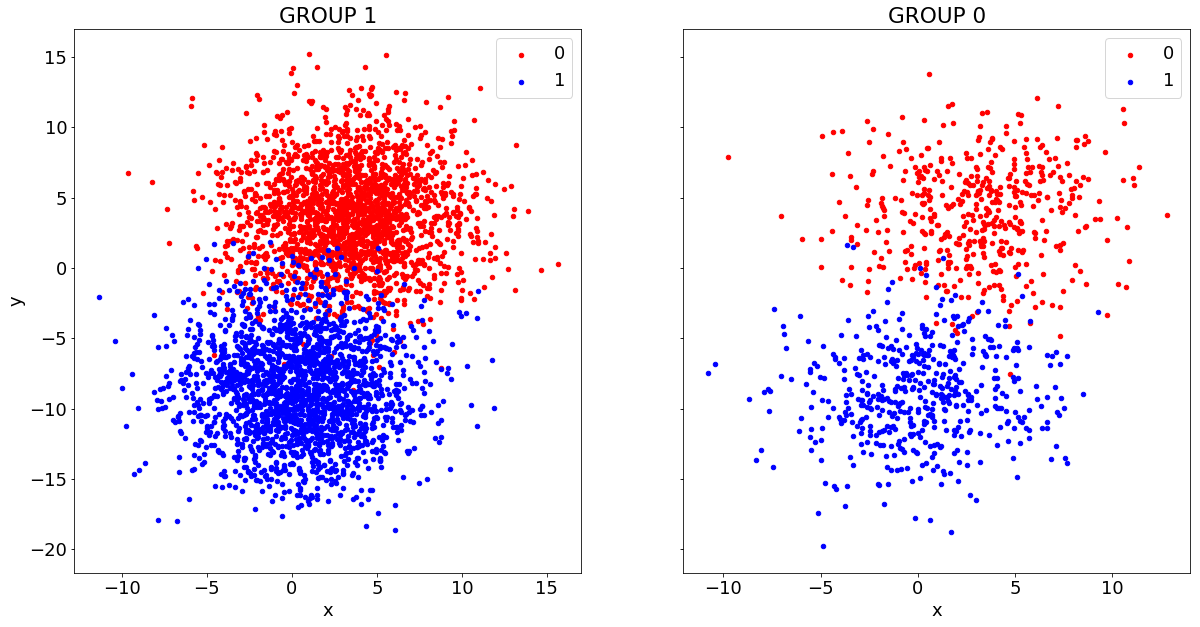

In [6]:
fig, ax = pyplot.subplots(ncols=2, sharey=True)
for index, pop in enumerate(df.population.unique()):
    df_pop = df[df.population == pop]
    grouped = df_pop.groupby('label')
    for key, group in grouped:
        group.plot(ax=ax[index], kind='scatter', x='x', y='y', label=key, color=colors[key], title=f'GROUP {pop}')
pyplot.show()

In [7]:
groups = df.groupby(['population', 'label']).size().unstack()
groups.div(groups.sum(axis=1), axis='rows').style.format(lambda x: f'{round(x* 100, 2) } %')

label,0,1
population,,
0,48.45 %,51.55 %
1,50.39 %,49.61 %


In [8]:
pd.crosstab(df.population, df.label, margins=True)

label,0,1,All
population,,,
0,483,514,997
1,2017,1986,4003
All,2500,2500,5000


In [9]:
control = df[df.label == 1]
test = df[df.label == 0]

In [10]:
m = Matcher(test, control, yvar="population", exclude=['label'])

Formula:
population ~ x+y
n majority: 4003
n minority: 997


In [11]:
m.fit_scores(balance=True, nmodels=200)

Fitting Models on Balanced Samples: 1\200Error: Unable to coerce to Series, length must be 1: given 1994
Fitting Models on Balanced Samples: 1\200Error: Unable to coerce to Series, length must be 1: given 1994
Fitting Models on Balanced Samples: 1\200Error: Unable to coerce to Series, length must be 1: given 1994
Fitting Models on Balanced Samples: 1\200Error: Unable to coerce to Series, length must be 1: given 1994
Fitting Models on Balanced Samples: 1\200Error: Unable to coerce to Series, length must be 1: given 1994

Average Accuracy: nan%


/opt/conda/lib/python3.7/site-packages/numpy/core/fromnumeric.py:2920: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/opt/conda/lib/python3.7/site-packages/numpy/core/_methods.py:85: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
